In [1]:
# Install Hugging Face transformers library.
# !pip install -q transformers

In [2]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob

/Users/jannichorst/Documents/code/trocr/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device = torch.device('mps')

## Download Data

In [4]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [5]:
URL = r"https://www.dropbox.com/scl/fi/jz74me0vc118akmv5nuzy/images.zip?rlkey=54flzvhh9xxh45czb1c8n3fp3&dl=1"
asset_zip_path = os.path.join(os.getcwd(), "images.zip")
# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

The `read_image()` function will take an image path as input, read the image, visualize it, and return the image.

In [6]:
def read_image(image_path):
    """
    :param image_path: String, path to the input image.

    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

The following `ocr()` functions performs Optical Character Recognition on a cropped image of text.

It takes the image in PIL format, passes it through the OCR processor and model and returns the generated text in String format.

In [7]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.

    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [8]:
def eval_new_data(data_path=None, num_samples=4, model=None):
    image_paths = glob.glob(data_path)
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_image(image_path)
        text = ocr(image, processor, model)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()

## Printed Text

In [9]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
model = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-small-printed'
).to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2 [00:00<?, ?it/s]/Users/jannichorst/Documents/code/trocr/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


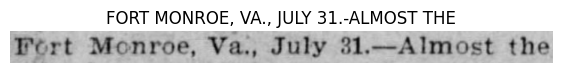

 50%|█████     | 1/2 [00:14<00:14, 14.79s/it]

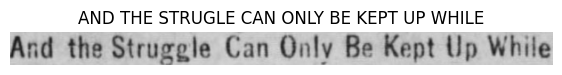

100%|██████████| 2/2 [00:15<00:00,  7.60s/it]


In [10]:
eval_new_data(
    data_path=os.path.join('images', 'newspaper', '*'),
    num_samples=2,
    model=model
)

## Handwritten Text

In [11]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-base-handwritten'
).to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2 [00:00<?, ?it/s]

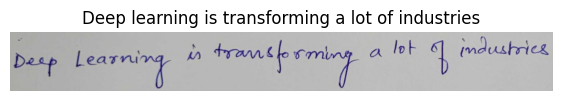

 50%|█████     | 1/2 [00:03<00:03,  3.12s/it]

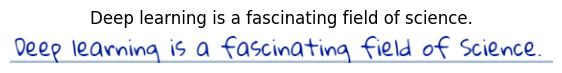

100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


In [12]:
eval_new_data(
    data_path=os.path.join('images', 'handwritten', '*'),
    num_samples=2,
    model=model
)

## Text in the Wild

In [13]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
model = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-small-printed'
).to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2 [00:00<?, ?it/s]

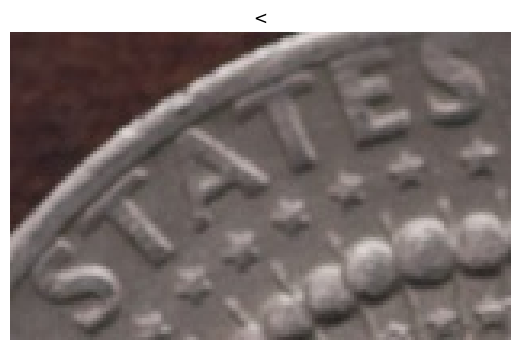

 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]

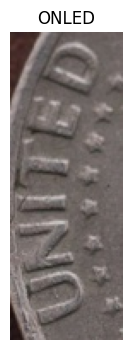

100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


In [14]:
eval_new_data(
    data_path=os.path.join('images', 'images_in_wild', '*'),
    num_samples=42,
    model=model
)